In [133]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
%matplotlib inline

In [135]:
'''
这些参数是根据经验以及结果来调整的，此参数组合可以让准确率到0.99
'''
#神经网络的学习率，先初始化为1e-4。
LEARNING_RATE = 1e-4
#迭代的次数
TRAINING_ITERATIONS = 2500
#后期使用dropout算法来防止过拟合，dropout值选择0.5,说明一层神经元会有一半将被屏蔽，使其激活址值为0。
DROPOUT = 0.5
#每50个样本用于计算梯度下降算法。
BATCH_SIZE = 50
#验证集的大小,此处取了整个train.csv的5%的大小，是后期调参调出来的，开始一般取10%-25%，慢慢降低比例。
VALIDATION_SIZE = 2000
#显示第十张图片。
IMAGE_TO_DISPLAY = 10

#读入训练集，在这之前要将csv保存为utf-8格式，否则会出现中文乱码的问题。
data = pd.read_csv('//Users//skyamz//Desktop//kaggledigit数据//train.csv')
#查看数据集有多少行多少列，显示数据集的前五行。
print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [136]:
#一行代表一张图，从第一列开始获取数据，因为第0列是"label"，即准确的是数字几的结果。不作为训练的数据，只用作结果的比对。
images = data.iloc[:,1:].values
images = images.astype(np.float)
''' convert from [0:255] => [0.0:1.0]。
    经过统计，最大的pixel为255，所以给images矩阵都乘以1.0 / 255.0来进行处理。
    图像像素在0-255之间为灰度图像，我们的图像已经是灰度图像了，但由于数量很大，为了节省空间，把0-255压缩在0-1之间做处理。
    之所以不映射二值图像图像，是因为信息损失太大，只有0，1两个数字，会造成判断的错误。
'''
images = np.multiply(images, 1.0 / 255.0)
#查看一下现在有多少张图片
print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


In [138]:
#images的shape属性现在为[42000，784]，所以images.shape[1]为784。即有42000张图片，每张有784个piexel来描述。
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))
# 一张图片，是用28*28=784个像素来表示的，即一个边长为28的正方形，所以image_width = image_height = 28。
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


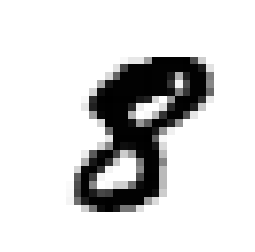

In [139]:
# 将其中一个图像画出来，观察一下样子。
def display(img):
    # (784) => (28,28)
    #将img矩阵从一行784列重塑成28行28列。
    one_image = img.reshape(image_width, image_height)
    #不显示坐标尺寸。
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
'''这里的binary，是以二进制的形式呈现图像。背景为白色，像素值越接近于1，就越黑，越接近于0越白
   我将binary改变成gray后，全部的黑白色都反转了。
'''
#显示第十个图片，查源数据可知应该显示数字'8'。
display(images[IMAGE_TO_DISPLAY])

In [140]:
'''ravel()函数返回的是这一列的视图，改变labels_flat的值时，原始的'label'也会改变。
   如果不想改变原始的'label'，则这里可以使用flatten()。
   labels_flat在这里存放的是结果集，即判断前面images是哪个数字。
'''
labels_flat = data['label'].values.ravel()
#一共有42000个图片。
print('labels_flat({0})'.format(len(labels_flat)))
#试着去查找第十个数，看输出是否为8。
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))
#统计有多少类数字，输出结果为10，即总共有十个数字，0-9。
labels_count = np.unique(labels_flat).shape[0]
print('labels_count => {0}'.format(labels_count))

labels_flat(42000)
labels_flat[10] => 8
labels_count => 10


In [141]:
'''convert class labels from scalars to one-hot vectors
   0 => [1 0 0 0 0 0 0 0 0 0]
   1 => [0 1 0 0 0 0 0 0 0 0]
   ...
   9 => [0 0 0 0 0 0 0 0 0 1]
   将结果集进行one-hot编码，具体见上面的注释说明。
'''
'''
要进行one-hot编码是因为要与最后计算结果做对比，如果只是一个数字的话，不能对比是否相同。
'''
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)
test = 'labels({0[0]},{0[1]})'.format(labels.shape)
print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [142]:
# 划分训练集和验证集。
'''由于前期不知道到底验证集要设定为多少，所以这里采用宏定义好调参。
   images属于narray结构，[行,列]。
   images[0]就表示images矩阵的第0行。
   images[:2]表示从最开始的第0行引用到第2行，即引用0，1行。（注意这里不包括第二行）
   images[2:]表示从第二行开始一直到最后。（这里包括第二行）
   只要后面没有逗号，都表示的是行。
'''
'''
   images[:,0]表示第0列（注意逗号和冒号）
   我们这里取的验证集validation_images是images的前VALIDATION_SIZE行，即取VALIDATION_SIZE个图片。
   取的训练集为images的VALIDATION_SIZE后面的所有行，即42000-VALIDATION_SIZE个图片。
'''
#同时取images（像素集合）和labels（对应的数字结果）
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]
train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]
'''
   train_images({0[0]},{0[1]})这种写法是通过下标来进行映射。由于我们不知道train_images.shape里面具体有什么，只能通过下标来获取。
'''
print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(40000,784)
validation_images(2000,784)


In [143]:
#Tensorflow图

In [144]:
#初始化权重
'''
    tf.truncated_normal产生正态分布的一个函数，shape表示生成张量的维度，mean是均值，这里等于0，stddev是标准差这里为0.1   
    这个函数产生的随机数与均值的差距不会超过两倍的标准差。
'''
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    #构造initial实例添加到图中
    return tf.Variable(initial)
#初始化偏值
def bias_variable(shape):
    #创建一个常量tensor，赋值为0.1，其形状为shape。
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [145]:
#卷积函数
'''
    tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
    input：需要做卷积的输入图像。它要求是一个Tensor，具有[batch, in_height, in_width, in_channels]这样的shape，
                                                [训练时一个batch的图片数量, 图片高度, 图片宽度, 图像通道数]
           注意这是一个4维的Tensor，要求类型为float32和float64其中之一
    
    filter：CNN中的卷积核。它要求是一个Tensor，具有[filter_height, filter_width, in_channels, out_channels]这样的shape，
                                            [卷积核的高度，卷积核的宽度，图像通道数，卷积核个数]
            要求类型与参数input相同，有一个地方需要注意，第三维in_channels，就是参数input的第四维
    strides：卷积时在图像每一维的步长，这是一个一维的向量，长度4
    padding：string类型的量，只能是"SAME","VALID"其中之一，这个值决定了不同的卷积方式。在边缘上的取样影响Conv层的面积，由于移动步长不一定能整除整张图的像素宽度，
             不越过边缘取样会得到Valid Padding， 越过边缘取样会得到Same Padding
    use_cudnn_on_gpu：bool类型，是否使用cudnn加速，默认为true
    name：指定该操作的名称
    具体如何进行卷积，请查看我的博客：http://blog.csdn.net/memoryjdch/article/details/75646487
'''
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [146]:
# pooling：在卷积之后的操作。将不同Stride的卷积用某种方式合并起来，节省卷积层的空间复杂度。
'''
    tf.nn.max_pool(value, ksize, strides, padding, name=None)
    value：需要池化的输入，一般池化层接在卷积层后面，所以输入通常是feature map，依然是[batch, height, width, channels]这样的shape。
    ksize：池化窗口的大小，取一个四维向量，一般是[1, height, width, 1]，因为我们不想在batch和channels上做池化，所以这两个维度设为了1。
    strides：和卷积类似，窗口在每一个维度上滑动的步长，一般也是[1, stride,stride, 1]。
    padding：和卷积类似，可以取'VALID' 或者'SAME'。
    返回一个Tensor，类型不变，shape仍然是[batch, height, width, channels]这种形式。
'''
'''
    我们这里是要用2*2的窗口来池化x，选择4个数中最大的那个，步长为2。
    例如：
    [[0,3],[4,2]] => 4
    [[0,1],[1,1]] => 1
'''
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [147]:
#神经网络的输入与输出
#创建图像的占位符，这里的None表示可以可以改变的，不固定的值
x = tf.placeholder('float', shape=[None, image_size])
#创建结果的占位符
y_ = tf.placeholder('float', shape=[None, labels_count])

In [148]:
#第一层卷积网络
'''
    一个权重矩阵和一个bias组成了一个kernel。一个kernel检测图片的一个特征。如果想要全方位的获取图片信息，则需要多个kernel
'''
#[5,5,1,32]表示用5*5的权重矩阵来计算图像的32个特性。1表示是灰度图像。
W_conv1 = weight_variable([5, 5, 1, 32])
#每个输出通道分量的偏置矢量为32
b_conv1 = bias_variable([32])


'''
    将图像转化为tensorflow格式，并重新表示为(40000,784) => (40000,28,28,1)
    -1代表的含义是不用我们自己指定这一维的大小，函数会自动计算，但列表中只能存在一个-1。
'''
image = tf.reshape(x, [-1,image_width , image_height,1])
print (image.get_shape())


'''
    ReLU（Rectified Linear unit）激活函数最近变成了神经网络中隐藏层的默认激活函数。
    这个简单的函数包含了返回max(0,x)，对于负值，它会返回0，其它返回x。
    我们这里在卷积层后的隐藏层中使用这个激活函数。
'''
#先卷积再池化
h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

# Prepare for visualization
# 以4*8的格式来显示32个特征
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))# => (40000, 28, 28, 4，8)
# 重新排序，让4和8处在前面，对应的x和y在后面
layer1 = tf.transpose(layer1, (0, 3, 1, 4, 2))# 0,3,1,4,2对应=> (40000, 4, 28, 8, 28)
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8))# => (40000, 112, 224)

(?, 28, 28, 1)
(?, 28, 28, 32)
(?, 14, 14, 32)


In [149]:
#  第二层卷积网络
#权重矩阵还是5*5，这里第二层网络的通道32，对应的是第一层网络的32个特征。64为输出通道的数量。
W_conv2 = weight_variable([5, 5, 32, 64])
#偏移量为64
b_conv2 = bias_variable([64])
#由于我们现在是要将第一层的结果（h_pool1）进行卷积，它已经是tensorflow格式的，不用再进行格式的转换。
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
print (h_pool2.get_shape()) # => (40000, 7, 7, 64)
#Prepare for visualization
#以4*16的格式来显示64个特征
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))
#重新排序，让4和16处在前面，对应的x和y在后面
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))
layer2 = tf.reshape(layer2, (-1, 14*4, 14*16))

(?, 14, 14, 64)
(?, 7, 7, 64)


In [150]:
'''
    经过第一二层的处理，图片大小由原来的28*28变成了7*7，且有64个特征值。
    这一步我们添加一个有1024个神经元的紧密连接层，每个神经元都连接到上一层的输出
'''
# 建立紧密连接层
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
# 把h_pool2_flat的结构从(40000, 7, 7, 64)变为(40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
print (h_fc1.get_shape())
# => (40000, 1024)

(?, 1024)


In [151]:
'''
    使用dropout技术，主要是为了防止过拟合。dropout主要是减少有效参数的数量
'''
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [152]:
'''
    添加softmax层。softmax模型可以用来给不同的对象分配概率。
    比如我们判断一张图片是9的概率为80%，判断为8的概率为5%，这个概率就是softmax分配的。
'''
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])
y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
print (y.get_shape())
# => (40000, 10)

(?, 10)


In [153]:
'''
    为了训练我们的模型，我们首先需要定义一个指标来评估这个模型是好的。
    在机器学习中，我们通常定义指标来表示一个模型是坏的，这个指标称为成本（cost）或损失（loss），然后尽量最小化这个指标。
'''
#损失函数：交叉熵
'''
    交叉熵可在神经网络(机器学习)中作为损失函数，p表示真实标记的分布，q则为训练后的模型的预测标记分布，交叉熵损失函数可以衡量p与q的相似性。
    交叉熵作为损失函数还有一个好处是使用sigmoid函数在梯度下降时能避免均方误差损失函数学习速率降低的问题，因为学习速率可以被输出的误差所控制。
    这里的交叉熵不仅仅用来衡量单一的一对预测和真实值，而是所有100幅图片的交叉熵的总和。
    对于100个数据点的预测表现比单一数据点的表现能更好地描述我们的模型的性能。
    如果想要更深入地理解交叉熵，请移步：http://colah.github.io/posts/2015-09-Visual-Information/
    如果想要通俗地理解交叉熵，请移步：https://www.zhihu.com/question/41252833的Agenter的回答
'''
#reduce_sum()计算所有元素的总和
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

In [154]:
#构造优化器
'''
    构造优化器AdamOptimizer，以LEARNING_RATE=1e-4的学习速率最小化交叉熵。
    这里本来是用梯度下降优化器的train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    但是我们用更复杂的Adam算法来代替梯度下降，结果更加准确。
'''
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

In [155]:
#评价模型
'''
    tf.argmax(y,1)意思是按行计算y中的最大值
    tf.equal(A,B)表示比较A，B对应元素是否相同，如果相同，返回true，否则返回false。返回的结构与A相同。
    tf.cast()函数是将correct_prediction的类型转化为float
    tf.reduce_mean求correct_prediction的平均值作为模型最终的的准确率
'''
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [156]:
#预测函数。取10个概率中最大的作为预测，例如：
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [157]:
#训练、验证和预测

In [158]:
#训练、验证和预测
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

In [159]:
#按照批次提供数据
'''
    关于batch_size、epochs、interations的说明：
    如果一个训练集中有1000条数据，每10条数据迭代一次，要迭代100次。
    那么batche_size=10，interations=100，每迭代完1000条数据，epochs=1
'''
def next_batch(batch_size):
    # 要进行训练的图像
    global train_images
    #要进行训练的结果
    global train_labels
    #当前训练的样本数
    global index_in_epoch
    #epochs计数
    global epochs_completed

    #从0开始，每调用一次函数就增加50个样本
    start = index_in_epoch
    index_in_epoch += batch_size

    # 当所有的训练集都被使用时, 再重新随机排序
    if index_in_epoch > num_examples:
        #每全部训练完一次，epoch+1
        epochs_completed += 1
        #迭代完之后，打乱数据
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        #重新开始下一轮epochs
        start = 0
        index_in_epoch = batch_size
        #断言：如果batch_size超出了数据集的范围，则返回异常
        assert batch_size <= num_examples
    end = index_in_epoch
    #每50个取一次，同时取图像和结果
    return train_images[start:end], train_labels[start:end]

In [160]:
#初始化变量，开始TensorFlow session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

In [161]:
#让变量可视化
#用来存放训练集准确率
train_accuracies = []
#用来存放验证集准确率
validation_accuracies = []
#存储i
x_range = []
#每迭代一步就显示一次
display_step = 1

for i in range(TRAINING_ITERATIONS):

    # get new batch
    #batch_xs存储的是图像的50个样本，batch_ys存储的是结果的50个样本
    batch_xs, batch_ys = next_batch(BATCH_SIZE)

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i % display_step == 0 or (i + 1) == TRAINING_ITERATIONS:
        #计算训练集准确率：把accuracy这个tensor用feed_dict这样的数据去flow它并打印出来。
        #eval函数相当于执行一次run函数
        #keep_prob: 1.0 表示这里不用dropout神经元
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs,
                                                  y_: batch_ys,
                                                  keep_prob: 1.0})
        if (VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={x: validation_images[0:BATCH_SIZE],
                                                           y_: validation_labels[0:BATCH_SIZE],
                                                           keep_prob: 1.0})
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d' % (
            train_accuracy, validation_accuracy, i))

            validation_accuracies.append(validation_accuracy)

        else:
            print('training_accuracy => %.4f for step %d' % (train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)

        # 如果大于10的话就每10步显示一次
        if i % (display_step * 10) == 0 and i:
            display_step *= 10
    # 每50个样本对整个图train_step进行训练，dropout率为0.5
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.16 / 0.14 for step 0
training_accuracy / validation_accuracy => 0.08 / 0.16 for step 1
training_accuracy / validation_accuracy => 0.08 / 0.18 for step 2
training_accuracy / validation_accuracy => 0.20 / 0.18 for step 3
training_accuracy / validation_accuracy => 0.22 / 0.14 for step 4
training_accuracy / validation_accuracy => 0.18 / 0.12 for step 5
training_accuracy / validation_accuracy => 0.22 / 0.14 for step 6
training_accuracy / validation_accuracy => 0.20 / 0.22 for step 7
training_accuracy / validation_accuracy => 0.14 / 0.24 for step 8
training_accuracy / validation_accuracy => 0.16 / 0.22 for step 9
training_accuracy / validation_accuracy => 0.16 / 0.20 for step 10
training_accuracy / validation_accuracy => 0.30 / 0.38 for step 20
training_accuracy / validation_accuracy => 0.66 / 0.66 for step 30
training_accuracy / validation_accuracy => 0.68 / 0.70 for step 40
training_accuracy / validation_accuracy => 0.74 / 0.72 for step 50
train

validation_accuracy => 0.9825


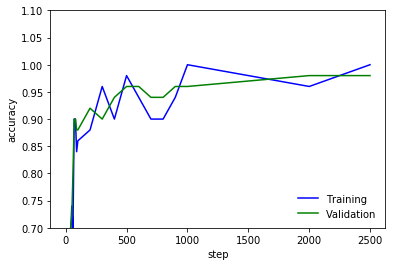

In [162]:
#在验证集上检查准确率，并画出每一步的准确率
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images,
                                                   y_: validation_labels,
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [163]:
#在测试集上面运行模型并观察结果
#读入测试集
test_images = pd.read_csv('//Users//skyamz//Desktop//kaggledigit数据//test.csv').values
test_images = test_images.astype(np.float)
#跟前面训练集处理数据一样，给每个pixel除以255 convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)
print('test_images({0[0]},{0[1]})'.format(test_images.shape))

test_images(28000,784)


In [164]:
#预测测试集
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})
#按照test.images的结构来创建一个全为0的矩阵
predicted_lables = np.zeros(test_images.shape[0])
#"//"操作为取整操作
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    #和前面训练集一样，每50个样本进行一次操作
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE],
                                                                                keep_prob: 1.0})
print('predicted_lables({0})'.format(len(predicted_lables)))

predicted_lables(28000)


predicted_lables[10] => 5.0


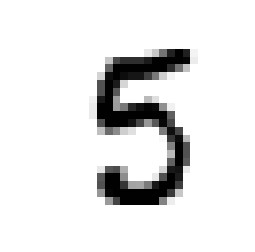

In [165]:
#输出预测的结果和图像
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

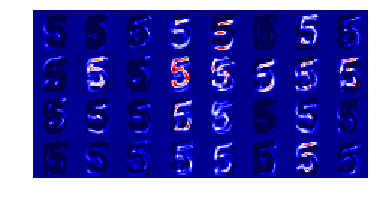

In [167]:
# save results
np.savetxt('submission_softmax.csv',
           np.c_[range(0,len(test_images)),predicted_lables],
           delimiter=',',
           header = 'ImageId,Label',
           comments = '',
           fmt='%d')

layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )

sess.close()